In [92]:
# Data manipulation
import pandas as pd
import numpy as np
# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline
MAX_EVALS = 100
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
import json
import shlex
import subprocess
import logging
from pprint import pprint
import re
import os


In [93]:
file_suffix = "temp" + str(MAX_EVALS)
def runthebenchmark(hyperparameters):
    os.chdir('/home/meghaagr/project/progress/active/../')
    storeinfile(hyperparameters)
    out=subprocess.Popen(["python3","read_config_general.py","-n 8","-c200 200 400 4 4 4 1"], shell=False, stdout=subprocess.PIPE)
    logging.basicConfig(level=logging.DEBUG)
    output=out.stdout.read().decode('utf-8')
    print("output"+output)
    if len(output.split(" ")) > 5:
        values = output.split(" ")
        value = float(float(values[6])*1024)/float(values[5]) + float(float(values[3])*1024)/float(values[2])
        value = float(value)
        print(value)
        return float((value/100)**3),output
    return 0,0

In [94]:
import json
from sklearn.externals import joblib
import os
os.chdir('/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active')


# Loading the model and scaler
filename="finalxgb.sav"
loaded_model = joblib.load(open(filename, 'rb'))
scaler_filename = "scalerxgb.save"
scaler = joblib.load(scaler_filename) 

In [95]:
def runfromsavedmodel(hyperparameters):
   # Active learning model choosees and saves the values of parameters
    storeinfile(hyperparameters)
    with open('/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active/confex.json') as f:
        data = json.load(f)

    romio_ds_read = data["mpi"]["romio_ds_read"] == "enable"
    romio_ds_write = data["mpi"]["romio_ds_write"] == "enable"
    cb_buffer_size = data["mpi"]["cb_buffer_size"]
    stripe_size = data["lfs"]["setstripe"]["size"]
    stripe_count = data["lfs"]["setstripe"]["count"]
    col_names =  ['cb5','cb6','cb7','cb8','cb8','cb10','cb11','cb12']
    cb_df  = pd.DataFrame(columns = col_names)
    cb_df.loc[len(cb_df)] = [romio_ds_read, romio_ds_write, stripe_size, stripe_count, cb_buffer_size,"75","75","75"]


    col_names =  ['0','1', '2','3','4','5']
    my_df = pd.DataFrame(columns=col_names)
    
    ### INITIALIZE THIS MANUALLY ####
    my_df.loc[len(my_df)] = [400,400,800,4,4,8]
    x = pd.concat([my_df,cb_df], axis=1)
    #normalize the test data
    norm_df = pd.DataFrame(scaler.transform(x))
    out = loaded_model.predict(norm_df)
    return float(1/float(out[0])),0
    

In [96]:
# # Import section
# import pickle
# import json
# from sklearn.externals import joblib
# import os
# os.chdir('/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active')


# # Loading the model and scaler
# filename="final.sav"
# loaded_model = pickle.load(open(filename, 'rb'))
# scaler_filename = "scaler.save"
# scaler = joblib.load(scaler_filename) 


In [97]:
# def runfromsavedmodel(hyperparameters):
#    # Active learning model choosees and saves the values of parameters
#     storeinfile(hyperparameters)
#     with open('/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active/confex.json') as f:
#         data = json.load(f)

#     cb_buffer_size = data["mpi"]["cb_buffer_size"]
#     stripe_size = data["lfs"]["setstripe"]["size"]
#     stripe_count = data["lfs"]["setstripe"]["count"]
#     col_names =  ['cb1', 'cb2', 'cb3']
#     cb_df  = pd.DataFrame(columns = col_names)
#     cb_df.loc[len(cb_df)] = [stripe_size, stripe_count, cb_buffer_size]

#     #normalize the test data
#     norm_df = scaler.transform( cb_df )
#     temp = pd.DataFrame(norm_df)

#     col_names =  ['0','1', '2','3','4','5']
#     my_df = pd.DataFrame(columns=col_names)
    
#     ### INITIALIZE THIS MANUALLY ####
#     my_df.loc[len(my_df)] = [300,300,300,2,2,4]
#     x = pd.concat([my_df,temp], axis=1)
#     out = loaded_model.predict(x)
#     return float(1/float(out[0])),0
    

In [98]:
def storeinfile(hyperparameters):
    data={"mpi": {"romio_ds_read": "enable", "romio_ds_write": "disable"}, "lfs": {"setstripe": {"size": "16777216", "count": 4}}}
    data["lfs"]["setstripe"]["size"] = int(hyperparameters["setstripe-size"])
    data["lfs"]["setstripe"]["count"] = int(hyperparameters["setstripe-count"])

    data["mpi"]["romio_ds_read"] = hyperparameters["romio_ds_read"]
    data["mpi"]["romio_ds_write"] = hyperparameters["romio_ds_write"]
    data["mpi"]["romio_cb_read"] = hyperparameters["romio_cb_read"]
    data["mpi"]["romio_cb_write"] = hyperparameters["romio_cb_write"]
    data["mpi"]["cb_buffer_size"] = str(int(hyperparameters["cb_buffer_size"]))
    with open("/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active/confex.json","w") as fp:
        json.dump(data,fp)
    print(data)


In [99]:
def objective(hyperparameters):
    global ITERATION
    ITERATION += 1
    start = timer()
    result=0
    while(result == 0):
        print("rerun")
        result,output = runfromsavedmodel(hyperparameters)
        print(result)
    run_time = timer() - start
    print({'loss': result, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK})
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([float(result), hyperparameters, ITERATION, run_time, output])
    return {'loss': float(result), 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK}

In [100]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

space = {
    'romio_ds_read' : hp.choice('romio_ds_read',['enable','disable']),
    'romio_ds_write' : hp.choice('romio_ds_write',['enable','disable']),
    'romio_cb_read' : hp.choice('romio_cb_read',['enable','disable']),
    'romio_cb_write' : hp.choice('romio_cb_write',['enable','disable']),
    'cb_buffer_size' : 1048576*hp.quniform('cb_buffer_size',1,512,1),
    'setstripe-size' : 65536*(hp.quniform('setstripe-size',0,512,1)),
    'setstripe-count' : hp.qloguniform('setstripe-count',0,5,1)
    
}

In [101]:
x = sample(space)
params = x
print(x)

cb_buffer_size_dist = []
for _ in range(1000):
    cb_buffer_size_dist.append(sample(space)['cb_buffer_size'])
    
setstripe_size_dist = []
for _ in range(1000):
    setstripe_size_dist.append(sample(space)['setstripe-size'])
    
setstripe_count_dist = []
for _ in range(1000):
    setstripe_count_dist.append(sample(space)['setstripe-count']) 
    
romio_ds_read_dist = []
for _ in range(20):
    romio_ds_read_dist.append(sample(space)['romio_ds_read'])
    
romio_ds_write_dist = []
for _ in range(20):
    romio_ds_write_dist.append(sample(space)['romio_ds_write'])
    
romio_cb_read_dist = []
for _ in range(20):
    romio_cb_read_dist.append(sample(space)['romio_cb_read']) 
    
romio_cb_write_dist = []
for _ in range(20):
    romio_cb_write_dist.append(sample(space)['romio_cb_write']) 
    

{'cb_buffer_size': 395313152.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 27.0, 'setstripe-size': 6488064.0}


In [102]:
# File to save first results
print(os.getcwd())
out_file = '/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active/result/gbm_trials-'+file_suffix+'.csv'

of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'train_time', 'output'])
of_connection.close()

/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active


In [103]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest


from hyperopt import Trials

# Record results
bayes_trials = Trials()

from hyperopt import fmin


ITERATION = 1

best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = bayes_trials, max_evals = MAX_EVALS)

rerun                                                
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '483393536'}, 'lfs': {'setstripe': {'size': 22740992, 'count': 33}}}
0.0011243526171290427                                
{'loss': 0.0011243526171290427, 'hyperparameters': {'cb_buffer_size': 483393536.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 33.0, 'setstripe-size': 22740992.0}, 'iteration': 2, 'iteration_time': 0.06536923399835359, 'status': 'ok'}
rerun                                                
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '480247808'}, 'lfs': {'setstripe': {'size': 18546688, 'count': 60}}}
0.0011394296342391928                                                            
{'loss': 0.00113942963

rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '384827392'}, 'lfs': {'setstripe': {'size': 23330816, 'count': 68}}}
0.0011394296342391928                                                             
{'loss': 0.0011394296342391928, 'hyperparameters': {'cb_buffer_size': 384827392.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 68.0, 'setstripe-size': 23330816.0}, 'iteration': 14, 'iteration_time': 0.06306294300156878, 'status': 'ok'}
rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '425721856'}, 'lfs': {'setstripe': {'size': 3276800, 'count': 1}}}
0.001848738149327

rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '460324864'}, 'lfs': {'setstripe': {'size': 29556736, 'count': 2}}}
0.001403861974251163                                                              
{'loss': 0.001403861974251163, 'hyperparameters': {'cb_buffer_size': 460324864.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 2.0, 'setstripe-size': 29556736.0}, 'iteration': 26, 'iteration_time': 0.04881772799853934, 'status': 'ok'}
rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '529530880'}, 'lfs': {'setstripe': {'size': 26607616, 'count': 11}}}
0.00106398889

rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '58720256'}, 'lfs': {'setstripe': {'size': 11403264, 'count': 5}}}
0.0014595207045893213                                                             
{'loss': 0.0014595207045893213, 'hyperparameters': {'cb_buffer_size': 58720256.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 5.0, 'setstripe-size': 11403264.0}, 'iteration': 38, 'iteration_time': 0.03406382899993332, 'status': 'ok'}
rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '497025024'}, 'lfs': {'setstripe': {'size': 27787264, 'count': 13}}}
0.00110689921008

rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '322961408'}, 'lfs': {'setstripe': {'size': 11730944, 'count': 148}}}
0.0013760267814587445                                                             
{'loss': 0.0013760267814587445, 'hyperparameters': {'cb_buffer_size': 322961408.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 148.0, 'setstripe-size': 11730944.0}, 'iteration': 50, 'iteration_time': 0.04030640000019048, 'status': 'ok'}
rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '275775488'}, 'lfs': {'setstripe': {'size': 9109504, 'count': 27}}}
0.0012027582

rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '352321536'}, 'lfs': {'setstripe': {'size': 4325376, 'count': 94}}}
0.0011729528414825539                                                             
{'loss': 0.0011729528414825539, 'hyperparameters': {'cb_buffer_size': 352321536.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 94.0, 'setstripe-size': 4325376.0}, 'iteration': 62, 'iteration_time': 0.044374849001542316, 'status': 'ok'}
rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '219152384'}, 'lfs': {'setstripe': {'size': 13107200, 'count': 18}}}
0.00117789220

rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '382730240'}, 'lfs': {'setstripe': {'size': 3538944, 'count': 46}}}
0.0011640170666613618                                                             
{'loss': 0.0011640170666613618, 'hyperparameters': {'cb_buffer_size': 382730240.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 46.0, 'setstripe-size': 3538944.0}, 'iteration': 74, 'iteration_time': 0.04898619199957466, 'status': 'ok'}
rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '258998272'}, 'lfs': {'setstripe': {'size': 5963776, 'count': 31}}}
0.001202758209995

rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '140509184'}, 'lfs': {'setstripe': {'size': 3604480, 'count': 22}}}
0.0012153196441243813                                                             
{'loss': 0.0012153196441243813, 'hyperparameters': {'cb_buffer_size': 140509184.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 22.0, 'setstripe-size': 3604480.0}, 'iteration': 86, 'iteration_time': 0.030273383999883663, 'status': 'ok'}
rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '37748736'}, 'lfs': {'setstripe': {'size': 6488064, 'count': 25}}}
0.00198219964394

rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '409993216'}, 'lfs': {'setstripe': {'size': 3997696, 'count': 3}}}
0.0011809294312495667                                                             
{'loss': 0.0011809294312495667, 'hyperparameters': {'cb_buffer_size': 409993216.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 3.0, 'setstripe-size': 3997696.0}, 'iteration': 98, 'iteration_time': 0.032073866999780876, 'status': 'ok'}
rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '15728640'}, 'lfs': {'setstripe': {'size': 8060928, 'count': 15}}}
0.0027042459583002

In [104]:
print(best)
d=  best
#print(bayes_trials.results)
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
#bayes_trials_results[:1]

{'cb_buffer_size': 468.0, 'romio_cb_read': 1, 'romio_cb_write': 0, 'romio_ds_read': 0, 'romio_ds_write': 0, 'setstripe-count': 9.0, 'setstripe-size': 0.0}


In [105]:
results = pd.read_csv(out_file)

# Sort with best scores on top and reset index for slicing
results.sort_values('train_time', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()


,loss,params,iteration,train_time,output
0,0.001206,"{'cb_buffer_size': 182452224.0, 'romio_cb_read...",55,0.028152,0
1,0.001215,"{'cb_buffer_size': 140509184.0, 'romio_cb_read...",86,0.030273,0
2,0.001176,"{'cb_buffer_size': 136314880.0, 'romio_cb_read...",17,0.031944,0
3,0.001181,"{'cb_buffer_size': 409993216.0, 'romio_cb_read...",98,0.032074,0
4,0.001128,"{'cb_buffer_size': 400556032.0, 'romio_cb_read...",64,0.032177,0


In [106]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()
print(best_bayes_params)
log = open('best.txt','a')
print(results.loc[0,'output'])
print(results.loc[0,'output'],file=log)
log.close()

{'cb_buffer_size': 182452224.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 27.0, 'setstripe-size': 2097152.0}
0


In [107]:
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
bayes_params['train_time'] = results['train_time']    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']
bayes_params['output']=results['output']

bayes_params.head()

,cb_buffer_size,romio_cb_read,romio_cb_write,romio_ds_read,romio_ds_write,setstripe-count,setstripe-size,train_time,loss,iteration,output
0,1.82452e+08,enable,disable,enable,enable,27,2.09715e+06,0.028152,0.001206,55,0
1,1.40509e+08,disable,disable,enable,enable,22,3.60448e+06,0.030273,0.001215,86,0
2,1.36315e+08,enable,enable,enable,disable,80,1.78258e+07,0.031944,0.001176,17,0
3,4.09993e+08,disable,enable,enable,enable,3,3.9977e+06,0.032074,0.001181,98,0
4,4.00556e+08,disable,enable,enable,enable,63,1.9202e+07,0.032177,0.001128,64,0


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


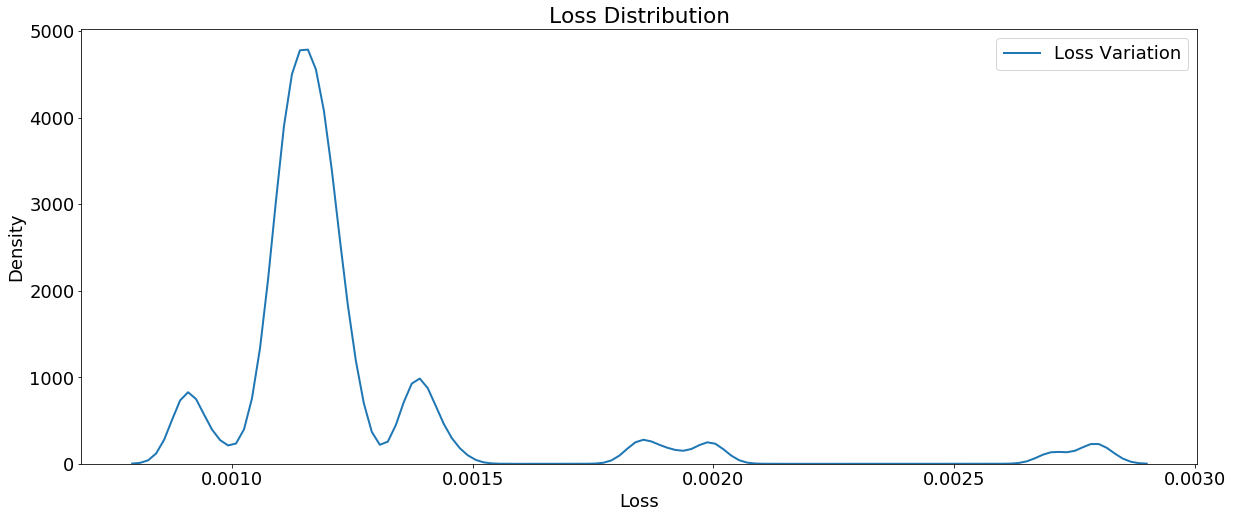

In [108]:
#os.chdir('./plots')
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['loss'], label = 'Loss Variation', linewidth = 2)
plt.legend()
plt.xlabel('Loss'); plt.ylabel('Density'); plt.title('Loss Distribution');
#plt.savefig(file_suffix+'_loss.png')

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


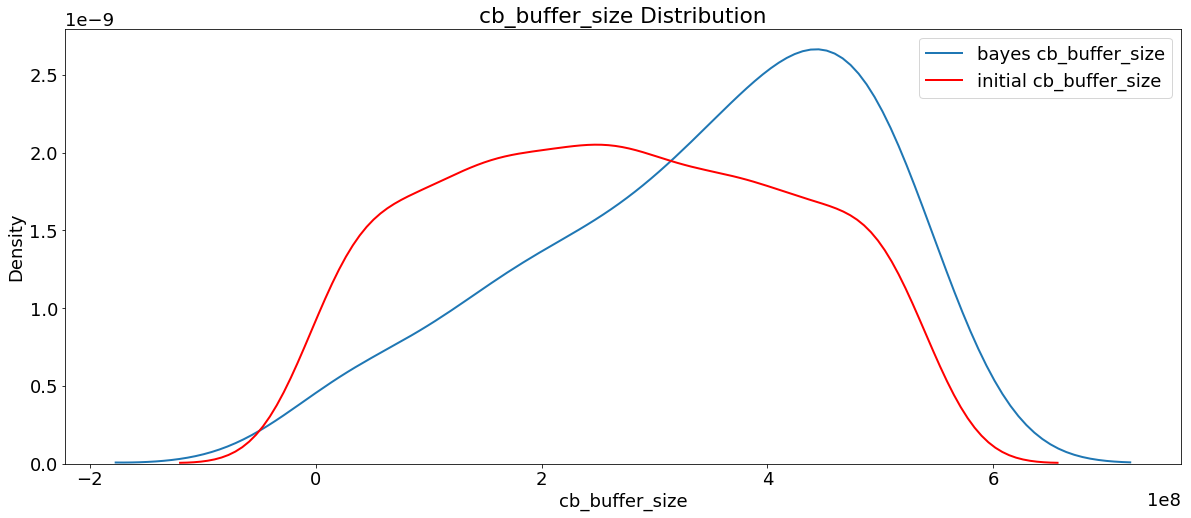

In [109]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18


sns.kdeplot(bayes_params['cb_buffer_size'], label = 'bayes cb_buffer_size', linewidth = 2)
sns.kdeplot(cb_buffer_size_dist,color="red",linewidth=2, label = 'initial cb_buffer_size')

plt.legend()
plt.xlabel('cb_buffer_size'); plt.ylabel('Density'); plt.title('cb_buffer_size Distribution');
#plt.savefig(file_suffix+'_cb_buffer_size.png')

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


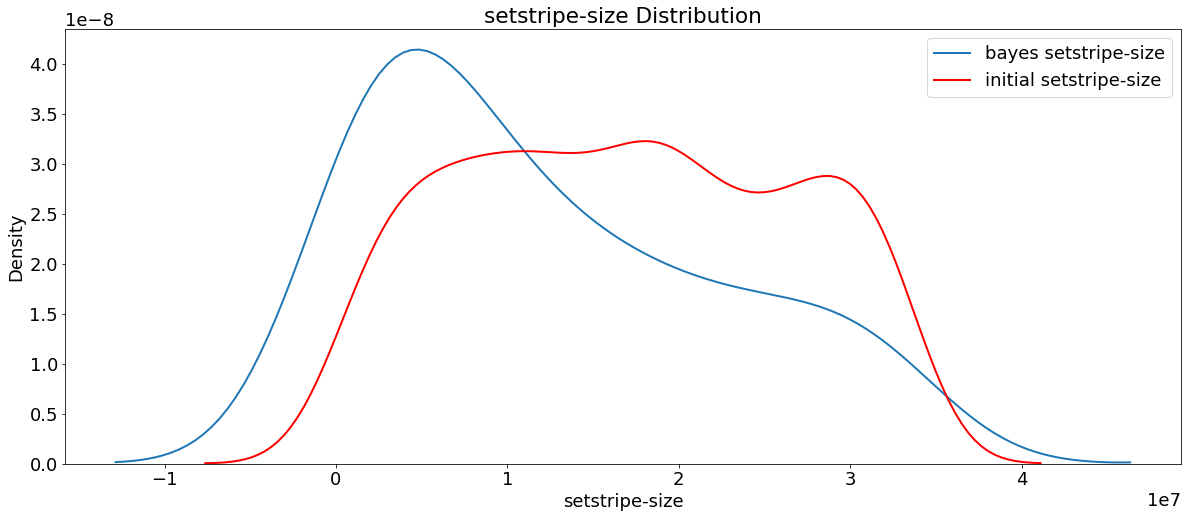

In [110]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-size'], label = 'bayes setstripe-size', linewidth = 2)
sns.kdeplot(setstripe_size_dist,color="red",linewidth=2, label = 'initial setstripe-size')

plt.legend()
plt.xlabel('setstripe-size'); plt.ylabel('Density'); plt.title('setstripe-size Distribution');
#plt.savefig(file_suffix+'_setstripe-size.png')

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


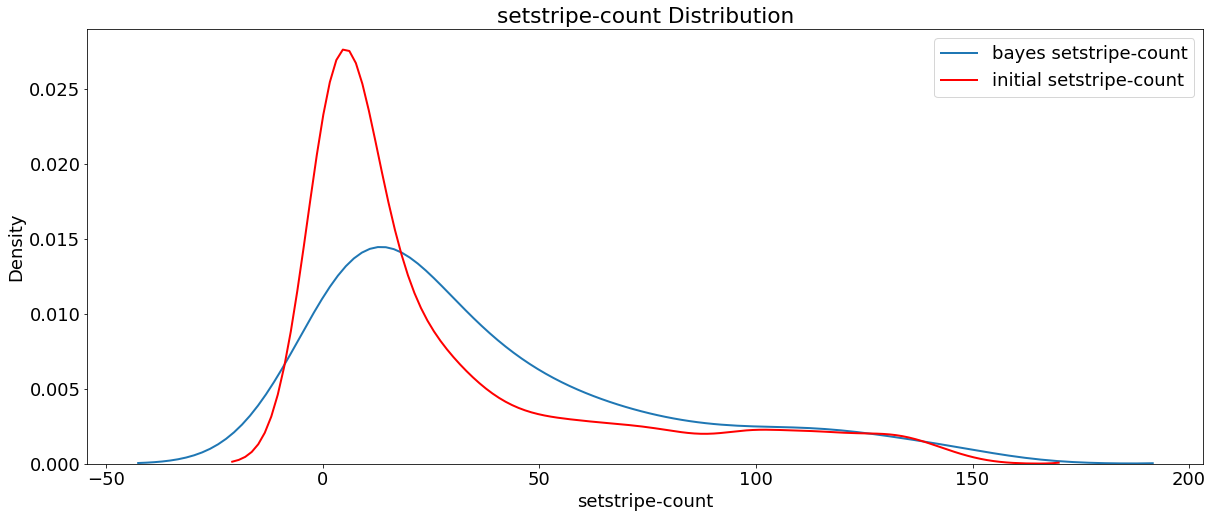

In [111]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-count'], label = 'bayes setstripe-count', linewidth = 2)
sns.kdeplot(setstripe_count_dist,color="red",linewidth=2, label = 'initial setstripe-count')

plt.legend()
plt.xlabel('setstripe-count'); plt.ylabel('Density'); plt.title('setstripe-count Distribution');
#plt.savefig(file_suffix+'_setstripe-count.png')

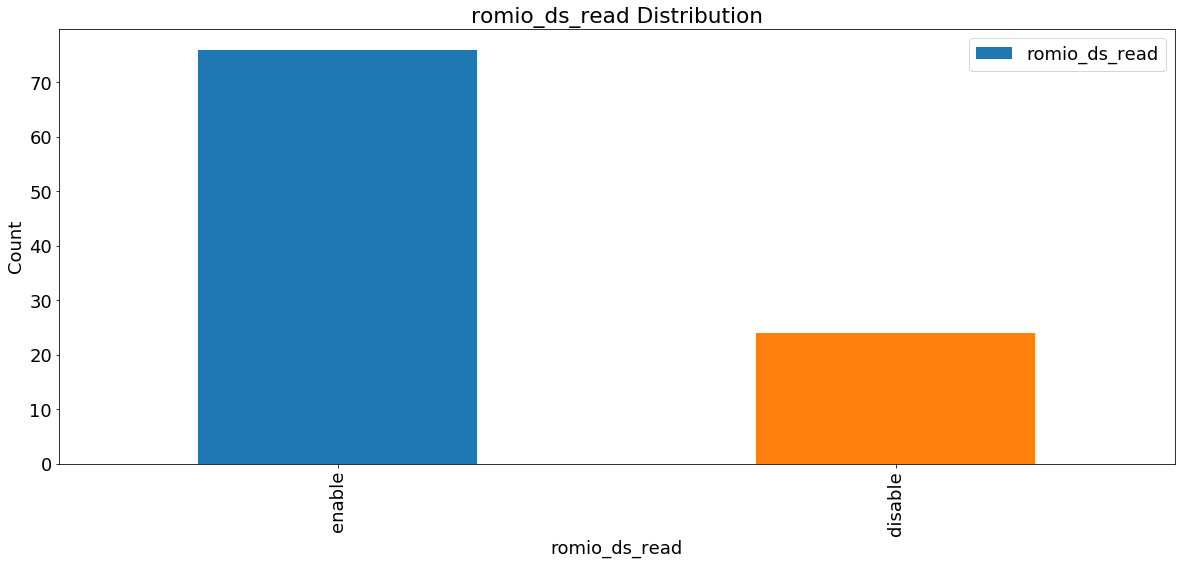

In [112]:
plt.figure(figsize = (20, 8))
from scipy.stats import itemfreq
plt.rcParams['font.size'] = 18
bayes_params['romio_ds_read'].value_counts().plot.bar()#plt.hist(romio_ds_read_dist,color="red",linewidth=2, label = 'initial romio_ds_read')

plt.legend()
plt.xlabel('romio_ds_read'); plt.ylabel('Count'); plt.title('romio_ds_read Distribution');
#plt.savefig(file_suffix+'_romio_ds_read.png')

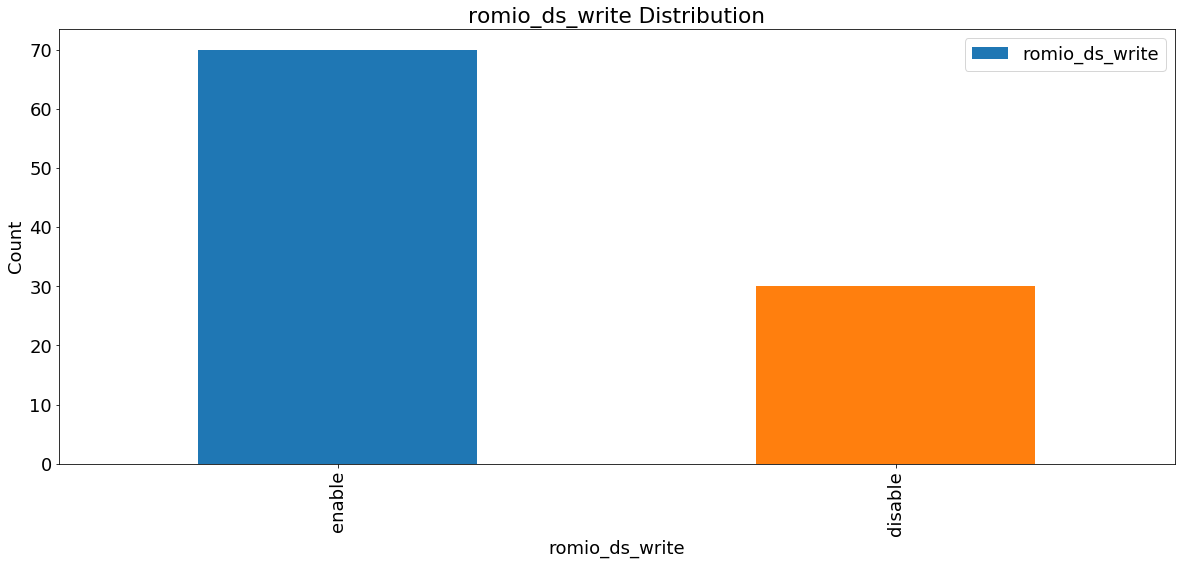

In [113]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

#plt.hist(bayes_params['romio_ds_write'], label = 'bayes romio_ds_write', linewidth = 2)
#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_ds_write')
bayes_params['romio_ds_write'].value_counts().plot.bar()
plt.legend()
plt.xlabel('romio_ds_write'); plt.ylabel('Count'); plt.title('romio_ds_write Distribution');
#plt.savefig(file_suffix+'_romio_ds_write.png')

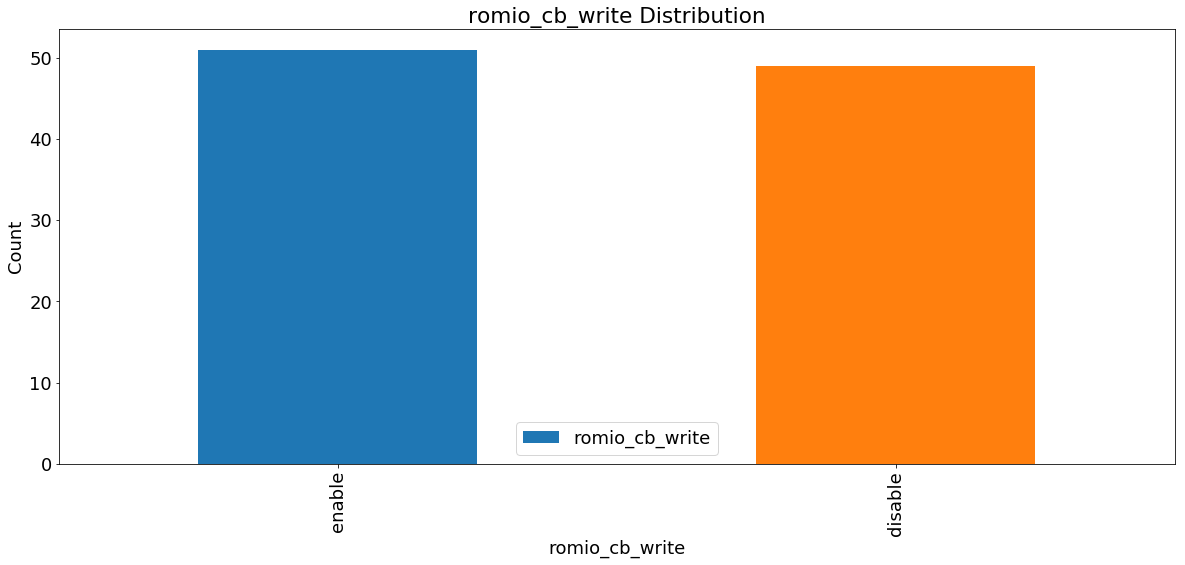

In [114]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

bayes_params['romio_cb_write'].value_counts().plot.bar()#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_cb_write')

plt.legend()
plt.xlabel('romio_cb_write'); plt.ylabel('Count'); plt.title('romio_cb_write Distribution');
#plt.savefig(file_suffix+'_romio_cb_write.png')

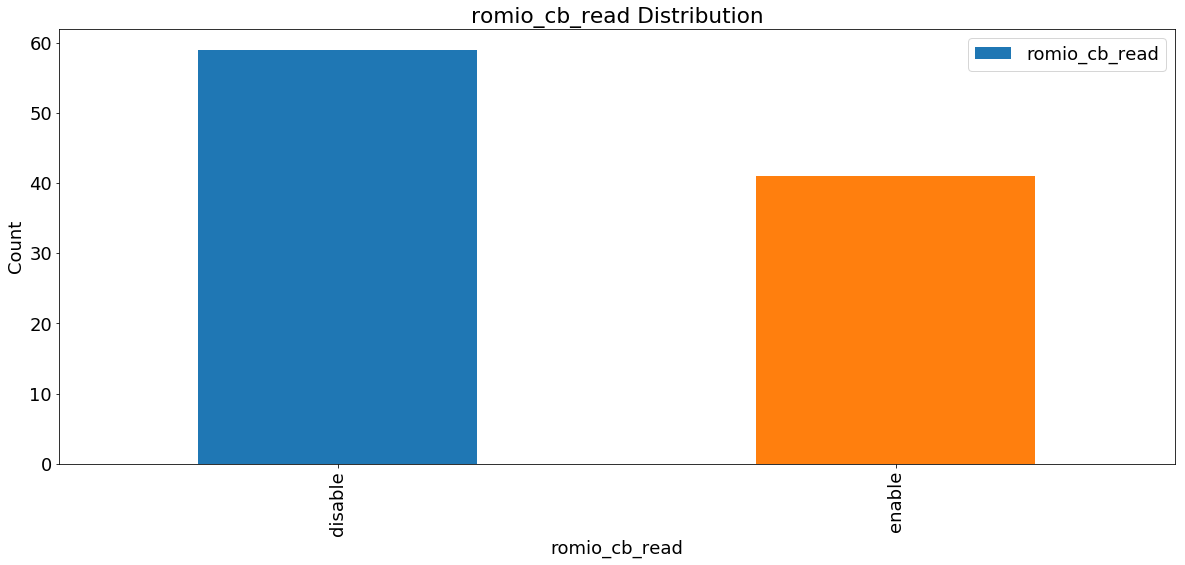

In [115]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

bayes_params['romio_cb_read'].value_counts().plot.bar()#plt.hist(romio_cb_read_dist,color="red",linewidth=2, label = 'initial romio_cb_read')

plt.legend()
plt.xlabel('romio_cb_read'); plt.ylabel('Count'); plt.title('romio_cb_read Distribution');
#plt.savefig(file_suffix+'_romio_cb_read.png')

In [116]:
os.chdir('../')